In [3]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
os.environ['THEANO_FLAGS'] = 'device=gpu'
import numpy as np
from keras.layers import *
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adadelta, RMSprop
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2, l1

Using Theano backend.
ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [17]:
def augment(x):
    x = x.copy()
    ind_z = np.random.choice((0, 1), size=x.shape[0])
    x[ind_z] = x[ind_z, ::-1, :, :]

    ind_y = np.random.choice((0, 1), size=x.shape[0])
    x[ind_y] = x[ind_y, :, ::-1, :]
    
    ind_x = np.random.choice((0, 1), size=x.shape[0])
    x[ind_x] = x[ind_x, :, :, ::-1] 
    return x

In [7]:
dataset = np.load('data.npz')
X_full = dataset['X']
X_full = X_full.reshape((X_full.shape[0], -1))
y = dataset['nMCparticles']
y_orig = y.copy()
y = to_categorical(y) 

X_full = X_full.reshape((X_full.shape[0], 18, 18, 30))

indices = np.arange(len(X_full))
np.random.shuffle(indices)
X_full = X_full[indices]
y_full = y[indices]

(array([ 181.,  330.,  611.,  806.,  700.,  862.,  140.,   74.,   32.,   15.]),
 array([  0. ,   1.2,   2.4,   3.6,   4.8,   6. ,   7.2,   8.4,   9.6,
         10.8,  12. ]),
 <a list of 10 Patch objects>)

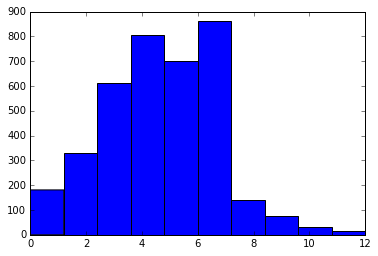

In [8]:
plt.hist(y_orig)

In [9]:
X_train = X_full[0:3000]
y_train = y_full[0:3000]
X_valid = X_full[3000:]
y_valid = y_full[3000:]

In [10]:
def build_model():
    
    inp = Input(shape=(X_full.shape[1], X_full.shape[2], X_full.shape[3]))
    
    x = inp
    
    
    x = Convolution2D(16, 3, 3, activation='relu')(x)
    x = Convolution2D(16, 3, 3, activation='relu')(x)
    x = Convolution2D(16, 3, 3, activation='relu')(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Convolution2D(64, 3, 3, activation='relu')(x)
    x = Convolution2D(64, 3, 3, activation='relu')(x)
    
    x = Flatten()(x)
    
    #x = Dense(100, activation='relu')(x)
    #x = Dense(100, activation='relu')(x)
    out = Dense(y.shape[1], activation='softmax')(x)

    model = Model(input=inp, output=out)
    optimizer = RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
model = build_model()

In [18]:
for i in range(30):
    X_train_ = augment(X_train)
    model.fit(X_train_, y_train, 
              verbose=1, 
              validation_data=(X_valid, y_valid),
              callbacks=[EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')],
              nb_epoch=1)

Train on 3000 samples, validate on 751 samples
Epoch 1/1
3000/3000 [==============================] - 7s - loss: 2.2461 - acc: 0.1753 - val_loss: 2.1592 - val_acc: 0.2130
Train on 3000 samples, validate on 751 samples
Epoch 1/1
3000/3000 [==============================] - 6s - loss: 2.1240 - acc: 0.2040 - val_loss: 2.1420 - val_acc: 0.2157
Train on 3000 samples, validate on 751 samples
Epoch 1/1
3000/3000 [==============================] - 6s - loss: 2.0932 - acc: 0.2233 - val_loss: 2.1351 - val_acc: 0.2197
Train on 3000 samples, validate on 751 samples
Epoch 1/1
3000/3000 [==============================] - 6s - loss: 2.0705 - acc: 0.2353 - val_loss: 2.1369 - val_acc: 0.2197
Train on 3000 samples, validate on 751 samples
Epoch 1/1
1952/3000 [==================>...........] - ETA: 2s - loss: 2.0514 - acc: 0.2382

ValueError: I/O operation on closed file

In [19]:
w = model.layers[2].W.get_value()
print(w.shape)
w = w[:, 7]
w = w.reshape((18, 18, 30))
for i in range(30):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(w[:, :, i], cmap='gray')
    plt.show()

(16, 16, 3, 3)


ValueError: total size of new array must be unchanged